# OnStove notebook

This is the OnStove notebook. The purpose of the notebook is to give users the ability to run through the analysis with example data and it can therefore act as a complement to the publication and read the docs documentation.

The notebook is divided into 4 major parts: 
* **Data processing** - In this part of the analysis different geospatial datasets are read and processed to be used in the analysis. The datasets from this step are saved on the users computer. For future runs on the same area of interest this step can consequently be skipped unless datasets are switched. 
* **Calibration** - In this part, the area of interest is calibrated. Raster cells are classified as either urban or rural, the electrification rate in different cells are determined and the rates of different cooking fuels across settlements are calibrated. The calibrated data is saved in .pkl-file. Unless data related to these steps are changed from one run to another, this step only needs to be ran once. 
* **Model run** - The net-benefit for different stoves are determined in different parts of the study area. Once all stoves have a net-benefit calculated the stoves will be compared and the stove with the highest net-benefit in each settlement is selected. Summaries of the results documenting the benefits and costs of each stove type across the entire study area are produced. The results are saved as .pkl-file.  
* **Visualization** - Visualizing and saving different maps related to the results.

Each part of the notebook is divided into several different cells and each cell is described more in depth. 

**Do not edit these cells**

In [1]:
import os, sys, requests, zipfile, yaml
import geopandas as gpd
sys.path.append("..")

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
from onstove import OnStove, DataProcessor, RasterLayer, VectorLayer
import time

### Create a data processor

This cell creates your dataprocessor. The dataprocessor is your model and will set the base for your model. OnStove is a raster-based model, hence the resolution becomes important. We specify the resolution when creating the dataprocessor together with the coordinate system. This will ensure that all rasters are resampled to the correct resolution and all datasets (vectors and rasters) are reprojected to the target coordinate system.

In this example we use the world mercator coordinate system (EPSG:3395) and a spatial resolution of 1 sq. km. To find a coordinate system suitable for your study area you can use [epsg.io](https://epsg.io/)

In [4]:
start = time.time()

data = DataProcessor(project_crs=3395, cell_size=(1000, 1000))
output_directory = '../example/results'
data.output_directory = output_directory

# Downloading example data from the Mendeley database

First the datasets need to be downloaded. The datasets needed for your analysis are saved on a Mendeley database. To know which datasets to download you need to enter the name of the country in the cell below. Available options are:
* Ghana
* ...
* ...
* ...

In [13]:
Country = 'Ghana'

In [4]:
country_dict = "https://data.mendeley.com/api/datasets/yk8pwfp2dt/draft/files/f7b8048e-5bd7-402a-806e-dd319e06ba23?a=6f59966f-57e7-403d-aa44-55be0d9363d5"
response = requests.get(country_dict)
open("country_dict.yaml", "wb").write(response.content)

with open("country_dict.yaml", 'r') as file:
    country_dict = yaml.safe_load(file)

**Downloading and saving the techno-economic specification file**

The cell below selects a techno-economic dataset to download based on the country name you provided above.

In [14]:
tech_specs = country_dict[Country]['tech']
response = requests.get(tech_specs)
open("tech_specs.csv", "wb").write(response.content)

8081

**Downloading and saving the socio-economic specification file**

The cell below selects a socio-economic dataset to download based on the country name you provided above.

In [15]:
soc_specs = country_dict[Country]['soc']
response = requests.get(soc_specs)
open("soc_specs.csv", "wb").write(response.content)

1426

**Downloading, saving and unzipping the GIS data**

The cell below geospatial datasets to download based on the country name you provided above.

In [16]:
gis_data = country_dict[Country]['GIS']
response = requests.get(gis_data)
open("gis_data.zip", "wb").write(response.content)

with zipfile.ZipFile("gis_data.zip","r") as zip_ref:
    zip_ref.extractall("gis_data")

# 1. Data processing

## 1.1. Add a mask and base 

The mask layer dictates what falls within your area of interest and what is excluded from your analysis. For mask layer we use the administrative boundaries of the country.

For this a function called *add_mask_layer* is used. *add_mask_layer* takes four inputs:
1. `category`- referencing the category of the layer
2. `name` - referencing the name of the layer
3. `path` - from where to read the data
4. `query` - string that can be used to filter the data
5. `postgres` - boolean determining whether the data is read from disc or from a PostgreSQL database. Default is `False`, meaning the dataset is read from disc.
6. `save_layer` -  determines whether the dataset is saved to disc or not. Default is `False`.

For more information about this function refer to the [documentation](https://onstove-documentation.readthedocs.io/en/latest/generated/onstove.DataProcessor.add_layer.html)

In [17]:
adm_path = r"../example/gis_data/Administrative/Country_boundaries/Country_boundaries.geojson"
data.add_mask_layer(category='Administrative', name='Country_boundaries', path=adm_path)

## 1.2. Add GIS layers

Similarly, we can add data layers using the `add_layer` method. A layer `name` and a `path` need ot be provided. In addition, the following arguments can be passed:
1. `category` - this is used to group all datasets into a category in the final output, e.g. `demand` or `supply`. 
2. `layer_type` - this argument is required with two possible options `raster` or `vector`, we should pass either one according to the dataset you are adding. 
3. `query` - string that can be used to filter the data
4. `postgres` - boolean determining whether the data is read from disc or from a PostgreSQL database. Default is `False`, meaning the dataset is read from disc.
5. `base_layer` - boolean determining whether the layer should be used as a `base_layer` for the data processing. Default is `False`. 
6. `resample` - this defines what resampling method to use when changing the resolution of the raster. The change of resolution happens when the layer gets aligned with the base layer (only applicable for rasters).
7. `normalization` - Set the method used for normalization if relevant at a later stage. Default is `MinMax`, which will normalize the layer using a MinMax approach. If the layer is of type vector the normalization method will be passed to any raster created using the vector.
8. `inverse` - Sets the default mode for the normalization algorithm. Default is `False`. 
9. `distance_method` - Sets the default distance algorithm to use when calling the `get_distance_raster` method for the layer.
10. `distance_limit` - Defines a distance limit or range to consider when calculating the distance raster.
11. `window` - A window or bounding box to read in the data if ``layer_type`` is `raster` or `vector` respectively
12. `rescale` - Sets the default value for the ``rescale`` attribute


Find more information about this function in the [documentation](https://onstove-documentation.readthedocs.io/en/latest/generated/onstove.DataProcessor.add_layer.html).

In the cells below the following datasets are read and processed:

* **Population** - a raster layer describing the spatial distribution of people across the study area
* **Urban-rural split** - a raster layer describing which areas that can be considered urban and rural respectively 
* **Forest** - a raster layer describing where forest is available and where it is not. This is used to estimate biomass collection time together with the friction layer.
* **Friction** - a raster layer describing the walking-only friction across the study area (the time it takes to travel across different cells of the study area by foot). This is used in order to determine the collection time of manure (for biogas) and biomass. 
* **Medium voltage lines** - a line vector showing the availability of medium voltage lines. This is used to estimate which settlements are electrified and which ones are not. Users can also use either transformers or high-voltage lines if available. 
* **Nighttime lights** - a raster showing the intensity of anthropogenic light. Used as proxy for determining who may have electricity and who does not. 
* **Travel time** - a map showing the time it takes to travel to the closest city of at least 50,000 people with motorized transport. This is used to estimate transportation cost of LPG. A user can also provide LPG supply points (as a point layer) and a motorized friction map to determine the travel time directly to the supply points.
* **Livestock** - raster layers showing the headcounts of different livestock (buffaloes, cattle, poultry, goats, pigs and sheep). This is used to assess the availability of manure in different cells of the study area. 
* **Temperature** - raster layer describing the temperature across the study area. This is to assess the suitability of using biogas. [If the average temperature decreases below 10 degrees Celsius the conversion of small scale biogas digesters reduces significantly making them unviable](https://www.sciencedirect.com/science/article/pii/S2213138821003118).

### 1.2.1. Demographics

In [18]:
pop_path = r"../example/gis_data/Population/Population.tif"
data.add_layer(category='Demographics', name='Population', 
               path=pop_path, layer_type='raster', resample='sum')

urban_path = r"../example/gis_data/Urban/Urban.tif"
data.add_layer(category='Demographics', name='Urban_rural_divide', 
               path=urban_path, layer_type='raster', resample='nearest')

### 1.2.2. Biomass

In [19]:
forest_path = r"../example/gis_data/Forest/Forest.tif"
data.add_layer(category='Biomass', name='Forest', 
               path=forest_path, layer_type='raster', resample='average')

friction_path = r"../example/gis_data/Friction/Friction.tif"
data.add_layer(category='Biomass', name='Friction', path=friction_path, 
               layer_type='raster', resample='average')

### 1.2.3. Electricity

In [20]:
mv_path = r"../example/gis_data/MV lines/MV_lines.geojson"
data.add_layer(category='Electricity', name='MV_lines', 
               path=mv_path, layer_type='vector')

ntl_path = r"../example/gis_data/Night time lights/Night_time_lights.tif"
data.add_layer(category='Electricity', name='Night_time_lights', 
               path=ntl_path, layer_type='raster', resample='average')

### 1.2.4. LPG

In [21]:
lpg_path = r"../example/gis_data/Traveltime/Traveltime.tif"
data.add_layer(category='LPG', name='LPG Traveltime', 
               path=lpg_path, layer_type='raster', resample='average')

### 1.2.5. Biogas

In [22]:
buffaloes = r"../example/gis_data/Livestock/buffaloes/buffaloes.tif"
cattles = r"../example/gis_data/Livestock/cattles/cattles.tif"
poultry = r"../example/gis_data/Livestock/poultry/poultry.tif"
goats = r"../example/gis_data/Livestock/goats/goats.tif"
pigs = r"../example/gis_data/Livestock/pigs/pigs.tif"
sheeps = r"../example/gis_data/Livestock/sheeps/sheeps.tif"

for key, path in {'buffaloes': buffaloes,
                  'cattles': cattles,
                  'poultry': poultry,
                  'goats': goats,
                  'pigs': pigs,
                  'sheeps': sheeps}.items():
    data.add_layer(category='Biogas/Livestock', name=key, path=path,
                   layer_type='raster', resample='nearest', rescale=True)

In [23]:
temperature = r"../example/gis_data/Temperature/Temperature.tif"
data.add_layer(category='Biogas', name='Temperature', path=temperature,
               layer_type='raster', resample='average')
data.layers['Biogas']['Temperature'].save(f'{data.output_directory}/Biogas/Temperature')

### 1.2.6. Base layer (forest layer)

Lastly a raster base layer is needed to make every output match its grid and extent. For this, we can also use the `add_layer` function.

In [24]:
data.add_layer(category='Base', name='Base', path=r"../example/gis_data/Forest/Forest.tif",
               layer_type='raster', base_layer=True, resample='nearest')

## 1.3. Mask, reproject, align and save all required layers

The cell below masks all datasets read in [cell 1.2](#1.2.-Add-GIS-layers) of the read datasets (rasters and vectors) and categorizes them in different groups.

Find more information about this function in the [documenation](https://onstove-documentation.readthedocs.io/en/latest/generated/onstove.DataProcessor.mask_layers.html).

In [25]:
data.mask_layers(datasets={'Demographics': ['Population', 'Urban_rural_divide'],
                           'Biomass': ['Forest', 'Friction'],
                           'Electricity': ['Night_time_lights', 'MV_lines'],
                           'LPG': ['LPG Traveltime'],
                           'Biogas': ['Temperature']})

All raster datasets are aligned with the base layer selected in [cell 1.2.6](#1.2.6.-Base-layer-(forest-layer)). The aligning function ensures that the coordinate system and resolution of all rasters are the same as the user specified when [creating the data processor](#Create-a-data-processor). 

Find more information about this function in the [documentation](https://onstove-documentation.readthedocs.io/en/latest/generated/onstove.DataProcessor.align_layers.html).

In [26]:
data.align_layers(datasets='all')

Next, all vector files (apart from the mask layer) are reprojected. This is done using the `reprojected_layers` function. The source coordinate system does not influence the process and the target coordinate system is the same as the one entered by the user when [creating the data processor](#Create-a-data-processor). 

Find more information about this function in the [documentation](https://onstove-documentation.readthedocs.io/en/latest/generated/onstove.DataProcessor.reproject_layers.html).

In [27]:
data.reproject_layers(datasets={'Electricity': ['MV_lines']})

Lastly, all processed layers (rasters, vectors, the base layer and the mask layer). This is done using the `save_datasets` function.

In [28]:
data.save_datasets('all')

In [29]:
end = time.time()

diff = end - start
print('Execution time:', str(str(int(diff//60))) + ' min ' + str(int((diff)%60)) + ' sec')

Execution time: 0 min 52 sec


# 2. Calibration

The calibration step does two things 1) it adds the datasets processed in the previous step to a settlement file that will be used in [step 3](#3.-Model-run) for determining the net-benefit in different settlements and 2) calibrates the file with regards to total population, urban-rural split and electrification rate. 

**Note:** Similar to the data processing step, this step is only needed once unless you change anything in the inputs

## 2.1. Read the model data

The cell below reads the socio-economic specification file. This file is needed as it contains the electrification and urban rates and the actual population in the study area (often the GIS datasets of populations have slightly outdated values of population). The scenario data is saved as a dictionary that can be called upon with `country.specs`

In [27]:
country = OnStove()
path = os.path.join('..', 'example','soc_specs.csv')
country.read_scenario_data(path, delimiter=',')

## 2.2. Add a population base layer

The population layer is read with `add_layer` and is turned into a dataframe with a column for population using the `population_to_dataframe`. This dataframe will be used to add all the other geospatial datasets and calculate the results on.

Find more information about these function in the [documentation](https://onstove-documentation.readthedocs.io/en/latest/generated/onstove.OnStove.population_to_dataframe.html)

In [28]:
path = os.path.join(output_directory,'Demographics','Population', 'Population.tif')
country.add_layer(category='Demographics', name='Population', path=path, layer_type='raster', base_layer=True)
country.population_to_dataframe()

## 2.3. Calibrate urban/rural split

The function `calibrate_urban_current_and_future_GHS` is used to classify different rows in of the dataframe produced in the previous step as either urban or rural. This is based on the [GHS dataset](https://ghsl.jrc.ec.europa.eu/download.php?ds=smod). This is important for the base year calculations as urban and rural shares of different stoves (and electrification rates) tend to differ.

Find more information about this function in the [documentation](https://onstove-documentation.readthedocs.io/en/latest/generated/onstove.OnStove.calibrate_urban_rural_split.html?highlight=GHS#onstove.OnStove.calibrate_urban_rural_split)

This function also calls on the `calibrate_current_pop` fuction to calibrate the population of the dataframe to the value entered in the socio-economic file.

Find more information about this function in the [documentation](https://onstove-documentation.readthedocs.io/en/latest/generated/onstove.OnStove.calibrate_current_pop.html).



In [30]:
ghs_path = output_directory + r"/Demographics/Urban_rural_divide/Urban_rural_divide.tif"
country.calibrate_urban_rural_split(ghs_path)

## 2.4. Add wealth index GIS data and determine the value of time

Here, the Relative Wealth Index (RWI) is added to the dataframe. The RWI is used to estimate the monetary value of time. The RWI can be read either as a csv-file, point, polygon or raster layer it is not read and added with the other datasets. Instead the function `extract_wealth_index` is used. 

Find more information about this function in the [documentation](https://onstove-documentation.readthedocs.io/en/latest/generated/onstove.OnStove.extract_wealth_index.html)

In [31]:
wealth_index = r"../example/gis_data/Relative wealth index/GHA_relative_wealth_index.csv"
country.extract_wealth_index(wealth_index, file_type="csv")

## 2.5. Calculate distance to electricity infrastructure 

To estimate electricity access rates in different cells across the study area the distance to electricity related infrastructure is important. The following section of the code reads the electricity related vector file(s) that was (were) processed in the data processing parts and determines the distance between every settlement (raster cell in the population map) and the closest infrastructure. This is done using a function called `distance_to_electricity`. 

Find more information about this function in the [documentation](https://onstove-documentation.readthedocs.io/en/latest/generated/onstove.OnStove.distance_to_electricity.html).

In [33]:
path = os.path.join(output_directory, 'Electricity', 'MV_lines', 'MV_lines.geojson')
mv_lines = VectorLayer('Electricity', 'MV_lines', path=path)
country.distance_to_electricity(mv_lines=mv_lines)

## 2.6. Add nighttime lights data

Nighttime lights are also important for the calibration of electrified population as it can give you an indication of where electricity consumption is present. The nighttime lights map should already have been processed in the [Data processing](#1.-Data-processing) section and therefore, it is only read here and added to the dataframe using the function `raster_to_dataframe`. 

Find out more the function in the [documentation](https://onstove-documentation.readthedocs.io/en/latest/generated/onstove.OnStove.raster_to_dataframe.html)

In [34]:
path = os.path.join(output_directory, 'Electricity', 'Night_time_lights', 'Night_time_lights.tif')
ntl = RasterLayer('Electricity', 'Night_time_lights', path=path)

country.raster_to_dataframe(ntl, name='Night_lights', method='read')

## 2.7. Calibrate current electrified population

Once the distance to electricity related infrastructure (transformers, MV-lines or HV-lines) is determined and the nighttime light intensity is extracted, the current electrification status for different settlements across the study area is determined. This is done in two steps. First, `current_elec` gives a binary classification of the settlements that are likely electrified (1 indicates that at least someone is likely to have access, while 0 indicates that electricity access is not present at all in the cell). 

For more information about the `current_elec` function, please refer to the [documentation](https://onstove-documentation.readthedocs.io/en/latest/generated/onstove.OnStove.current_elec.html)

Once the binary classification is made the electrification rate in the different cells with the value 1 from the current_elec is determined. This is done using the function final_elec. This is a multi-criteria analysis taking into account the population density in each cell, the nighttime light intensity and the distance to either transformers, MV-lines or HV-lines together with weights for each one of these factors provided by the user in the socio-economic specs file.  

For more information about the `final_elec` function, please refer to the [documentation](https://onstove-documentation.readthedocs.io/en/latest/generated/onstove.OnStove.final_elec.html)

In [35]:
country.current_elec()
country.final_elec()

print('Calibrated grid electrified population fraction:', country.gdf['Elec_pop_calib'].sum() / country.gdf['Calibrated_pop'].sum())

Calibrated grid electrified population fraction: 0.8492509300597771


## 2.8. Read the cooking technologies data

The techno-economic specification file is read. This file does two things: 1) it determines the available fuel/stove combinations used in the analysis and 2) it indicates different techno-economic parameters related to these stoves. If a stove is to be added to the analysis the first step is to add it in this file. The function `read_tech_data` creates a dictionary of technology-classes. This dictionary can be called with `country.techs`

Find out more about this function in the [documentation](https://onstove-documentation.readthedocs.io/en/latest/generated/onstove.OnStove.read_tech_data.html).

In [36]:
path = os.path.join('..', 'example', 'tech_specs.csv')
country.read_tech_data(path, delimiter=',')

## 2.9. Calculating grid added capacity cost

The following cell is used in order to determine the cost of added capacity. For each new household cooking with electricity there is a need to invest in added capacity. The function `get_capacity_cost` determines this cost by taking into account the different power plants costs and the current electricity mix in the study area (both from the techno-economic specification file). 

Find out more about this function in the [documentation](https://onstove-documentation.readthedocs.io/en/latest/generated/onstove.Electricity.get_capacity_cost.html).

In [37]:
country.techs['Electricity'].get_capacity_cost(country)

## 2.10. Reading GIS data for LPG supply

The LPG travel time is added to the dataframe. The original dataset gives the time in minutes, so here the values are divided by 60 to ensure that the time worked with is in hours. A factor of 2 is also multiplied with the travel time to account for the fact that the trips are two-ways. 

In [38]:
lpg = RasterLayer('LPG', 'LPG Traveltime', 
                  os.path.join(output_directory, 'LPG', 'LPG Traveltime', 'LPG Traveltime.tif'))

country.techs['LPG'].travel_time = country.raster_to_dataframe(lpg, fill_nodata_method='interpolate', 
                                                               method='read') * 2 / 60

## 2.11. Adding GIS data for Biogas

Biogas potential is dependent on the availability of manure, the availability of manure is in turn dependent on livestock. The cell below determines and adds the livestock to the dataframe. Apart from adding the livestock datasets to the dataframe, the cell below also takes into account the temperature [(temperatures below 10 degrees Celsius render the biogas digesters too inefficient)](https://www.sciencedirect.com/science/article/pii/S2213138821003118) and adds a friction map (walking only friction that is also used for biomass in order to estimate the travel time for biogas collection). 

Find out more the calibration of livestock in the [documentation](https://onstove-documentation.readthedocs.io/en/latest/generated/onstove.Biogas.recalibrate_livestock.html).

In [39]:
amin = gpd.read_file(os.path.join(output_directory, 'Administrative', 'Country_boundaries', 'Country_boundaries.geojson'))
buffaloes = os.path.join(output_directory, 'Biogas', 'Livestock', 'buffaloes', 'buffaloes.tif')
cattles = os.path.join(output_directory, 'Biogas', 'Livestock', 'cattles', 'cattles.tif')
poultry =os.path.join(output_directory, 'Biogas', 'Livestock', 'poultry', 'poultry.tif')
goats = os.path.join(output_directory, 'Biogas', 'Livestock', 'goats', 'goats.tif')
pigs = os.path.join(output_directory, 'Biogas', 'Livestock', 'pigs', 'pigs.tif')
sheeps = os.path.join(output_directory, 'Biogas', 'Livestock', 'sheeps', 'sheeps.tif')

country.techs['Biogas'].temperature = os.path.join(output_directory, 'Biogas', 'Temperature', 'Temperature.tif')
country.techs['Biogas'].recalibrate_livestock(country, buffaloes, cattles, poultry, goats, pigs, sheeps)
country.techs['Biogas'].friction_path = os.path.join(output_directory, 'Biomass', 'Friction', 'Friction.tif')

## 2.12. Adding GIS data for Biomass

Biomass is assumed to be collected by the end-users themselves. In this notebook three biomass stoves are present (traditional biomass, natural draft (Collected Improved biomass) and forced draft. For each one of these stoves the forest and friction layers are added to their respective classes. The forest layer describes where the collection opportunities for biomass exist, while the friction map (only walking-friction) is used to determine the least-cost path to the different collection points on the map. The collection point with the lowest travel time is selected for biomass collection. The user can also give a condition for where collection can be carried out using the `forest_condition` call. The condition restricts certain areas based on canopy cover. In this example no such restriction is given.

Find out more about how biomass is treated in the [documentation](https://onstove-documentation.readthedocs.io/en/latest/generated/onstove.Biomass.html).

In [40]:
country.techs['Biomass Forced Draft'].friction_path = os.path.join(output_directory, 'Biomass', 'Friction', 'Friction.tif')
country.techs['Biomass Forced Draft'].forest_path = os.path.join(output_directory, 'Biomass', 'Forest', 'Forest.tif')
country.techs['Biomass Forced Draft'].forest_condition = lambda x: x > 0

country.techs['Collected_Improved_Biomass'].friction_path = os.path.join(output_directory, 'Biomass', 'Friction', 'Friction.tif')
country.techs['Collected_Improved_Biomass'].forest_path = os.path.join(output_directory, 'Biomass', 'Forest', 'Forest.tif')
country.techs['Collected_Improved_Biomass'].forest_condition = lambda x: x > 0

country.techs['Collected_Traditional_Biomass'].friction_path = os.path.join(output_directory, 'Biomass', 'Friction', 'Friction.tif')
country.techs['Collected_Traditional_Biomass'].forest_path = os.path.join(output_directory, 'Biomass', 'Forest', 'Forest.tif')
country.techs['Collected_Traditional_Biomass'].forest_condition = lambda x: x > 0

## 2.13. Saving the prepared model inputs

The cell below saves the dataframe created through the calibration-phase as a .pkl-file. This enables users to run several scenarios on the same file without rerunning the previous steps. 

In [21]:
country.output_directory = r"."

country.to_pickle("model_inputs.pkl")

end = time.time()

diff = end - start
print('Execution time:', str(str(int(diff//60))) + ' min ' + str(int((diff)%60)) + ' sec')

Execution time: 6 min 38 sec


# 3. Model run

This section runs the main-analysis and produces the results of OnStove. In this section first the cooking options currently in place are determined for urban and rural settlements. This base-line cooking mix is used in order to determine the relative benefits (reduced mortality, reduced morbidity, time saved and carbon emissions avoided), as well as the relative costs (investments, operation & maintenance, fuel and salvage costs). The benefits and costs for all stove options are combined in every cell to produce the net-benefit (defined as benefits minus costs). The stove with the highest net-benefit is selected for each cell in the study area.

The first two cells in this section reads: 1) the model inputs (output from the calibration phase) and 2) the socio-economic specification file. 

In [5]:
start = time.time()
country = OnStove.read_model("model_inputs.pkl")

In [6]:
path = os.path.join('..', 'example', 'soc_specs.csv')
country.read_scenario_data(path)

## 3.1 Calculating benefits and costs of each technology and getting the max benefit technology for each cell

The cell below runs the analysis for the technologies specified in the list called `names`. **Note: the technologies in the name list also have to be present in the techno-economic file, otherwise the run will crash.**

The run function calculates all benefits and costs. It also determines the net-benefit and selects the stove with the highest net-benefit. 

For more information on this function, refer to the [documentation](https://onstove-documentation.readthedocs.io/en/latest/generated/onstove.OnStove.run.html)

In [7]:
names = ['Electricity','Traditional_Charcoal' ,'Charcoal ICS' ,
         'LPG', 'Biogas', 'Collected_Traditional_Biomass', 
         'Collected_Improved_Biomass', 'Biomass Forced Draft', 'Pellets Forced Draft']
country.run(technologies=names) 

[Ghana] Calculating clean cooking access
[Ghana] Getting value of time
[Ghana] Calculating base fuel properties
The sum of rural technology shares you provided in the tech specs does not equal 1.0. 
The shares have been adjusted to make the sum 1.0 as follows. 
If you are not satisfied then please adjust the shares to your liking manually in the tech specs file.
Biogas 0.0
Biomass Forced Draft 0.0
Charcoal ICS 0.0
Collected_Improved_Biomass 0.0
Collected_Traditional_Biomass 0.6923648806917131
Electricity 0.002474768563310283
Kerosene 0.0002546058192706053
LPG 0.11296860201036756
Pellets Forced Draft 0.0
Traditional_Charcoal 0.1919371429153385
The sum of urban technology shares you provided in the tech specs does not equal 1.0. 
The shares have been adjusted to make the sum 1.0 as follows. 
If you are not satisfied then please adjust the shares to your liking manually in the tech specs file.
Biogas 0.0
Biomass Forced Draft 0.0
Charcoal ICS 0.0
Collected_Improved_Biomass 0.0
Collected_Tr

## 3.2. Printing the summaries

Prints the summary of the results. Note that the results are relative to the base-line, so in some cases costs and benefits can be negative. For each stove in the results the table includes:

* Population using the stove
* Households using the stove
* Total net-benefit generated across the study area due to the use of the stove
* Total number deaths avoided across the study area due to the use of the stove
* The total health costs avoided by using the stove across the study area
* Hours saved by adopting each stove for every household on average
* Opportunity cost due to time saved for each stove type across the study area
* Emissions avoided across the study area due to the use of each stove
* Emission costs avoided across the study area due to the use of each stove
* Total investment costs
* Total fuel costs
* Total O&M costs (operation and maintenance) 
* Total salvage costs

Each summary statistics area also aggregated across the entire study area.

In [8]:
country.summary()

,Max benefit technology,Population (Million),Households (Millions),Total net benefit (MUSD),Total deaths avoided (pp/yr),Health costs avoided (MUSD),hours/hh.day,Opportunity cost avoided (MUSD),Reduced emissions (Mton CO2eq),Emissions costs saved (MUSD),Investment costs (MUSD),Fuel costs (MUSD),O&M costs (MUSD),Salvage value (MUSD)
0,Biogas,0.509618,0.063702,86.743426,242.472669,75.780381,0.224153,0.543243,0.226707,11.562045,34.668405,-1.632205,0.202809,32.096767
1,Electricity,26.388776,3.727771,3516.71584,10735.104846,3402.883331,0.836566,149.461474,9.742363,496.860525,542.845608,51.87419,8.492236,70.722543
2,LPG,4.174608,0.522224,664.289159,1982.160561,619.495421,1.148807,22.499612,1.600595,81.630322,21.630115,53.35311,1.660335,17.307363
total,total,31.073002,4.313698,4267.748424,12959.738076,4098.159133,0.865323,172.504329,11.569665,590.052892,599.144128,103.595096,10.35538,120.126673


## 3.3. Saving the results

Saves the full results as .pkl-file. It is important to change the name each time you run a scenario to avoid overwriting your old results.

In [9]:
country.to_pickle("results.pkl")

# 4. Visualization

The section below gives an indication of what can be visualized using the OnStove results. Note that the actual result files include more information that can also be visualized and extracted for later use. 

## 4.1. Reading the results

First we read in the results produced in [step 3](#3.-Model-run).

In [5]:
results = OnStove.read_model("results.pkl")

## 4.2. Add a country mask layer

We read the administrative boundaries polygon. This will be used as a backdrop for the maps. 

In [6]:
path = os.path.join(output_directory,'Administrative','Country_boundaries', 'Country_boundaries.geojson')
mask_layer = VectorLayer('admin', 'adm_0', path=path)
results.mask_layer = mask_layer

## 4.3. Setting the color palette and label names

Setting the color palette for visualization of the maps and graphs. These are dictionaries containing all the stoves included in the analysis and their html-coded colors.

In [7]:
cmap = {"Biomass ICS (ND)": '#6F4070', "LPG": '#66C5CC', "Biomass": '#FFB6C1',
        "Biomass ICS (FD)": '#af04b3', "Pellets ICS (FD)": '#ef02f5',
        "Charcoal": '#364135', "Charcoal ICS": '#d4bdc5',
        "Biogas": '#73AF48', "Biogas and Biomass ICS (ND)": "#F6029E",
        "Biogas and Biomass ICS (FD)": "#F6029E",
        "Biogas and Pellets ICS (FD)": "#F6029E",
        "Biogas and LPG": "#0F8554", "Biogas and Biomass": "#266AA6",
        "Biogas and Charcoal": "#3B05DF",
        "Biogas and Charcoal ICS": "#3B59DF",
        "Electricity": '#CC503E', "Electricity and Biomass ICS (ND)": "#B497E7",
        "Electricity and Biomass ICS (FD)": "#B497E7",
        "Electricity and Pellets ICS (FD)": "#B497E7",
        "Electricity and LPG": "#E17C05", "Electricity and Biomass": "#FFC107",
        "Electricity and Charcoal ICS": "#660000",
        "Electricity and Biogas": "#f97b72",
        "Electricity and Charcoal": "#FF0000"}

labels = {"Biogas and Electricity": "Electricity and Biogas",
          'Collected Traditional Biomass': 'Biomass',
          'Collected Improved Biomass': 'Biomass ICS (ND)',
          'Traditional Charcoal': 'Charcoal',
          'Biomass Forced Draft': 'Biomass ICS (FD)',
          'Pellets Forced Draft': 'Pellets ICS (FD)'}

## 4.4. Printing map with stoves with highest net-benefit in each settlement

Visualize maps of the stoves with the highest net-benefits together with some important summary results. 

Find out more about this function in the [documentation](https://onstove-documentation.readthedocs.io/en/latest/generated/onstove.OnStove.plot.html).


['LPG', 'Biogas', 'Biogas and LPG', 'Electricity', 'Electricity and LPG', 'Electricity and Biogas']
[2, 8, 12, 16, 20, 23]


<AxesSubplot:title={'left':'Maximum net-benefit cooking technology'}>

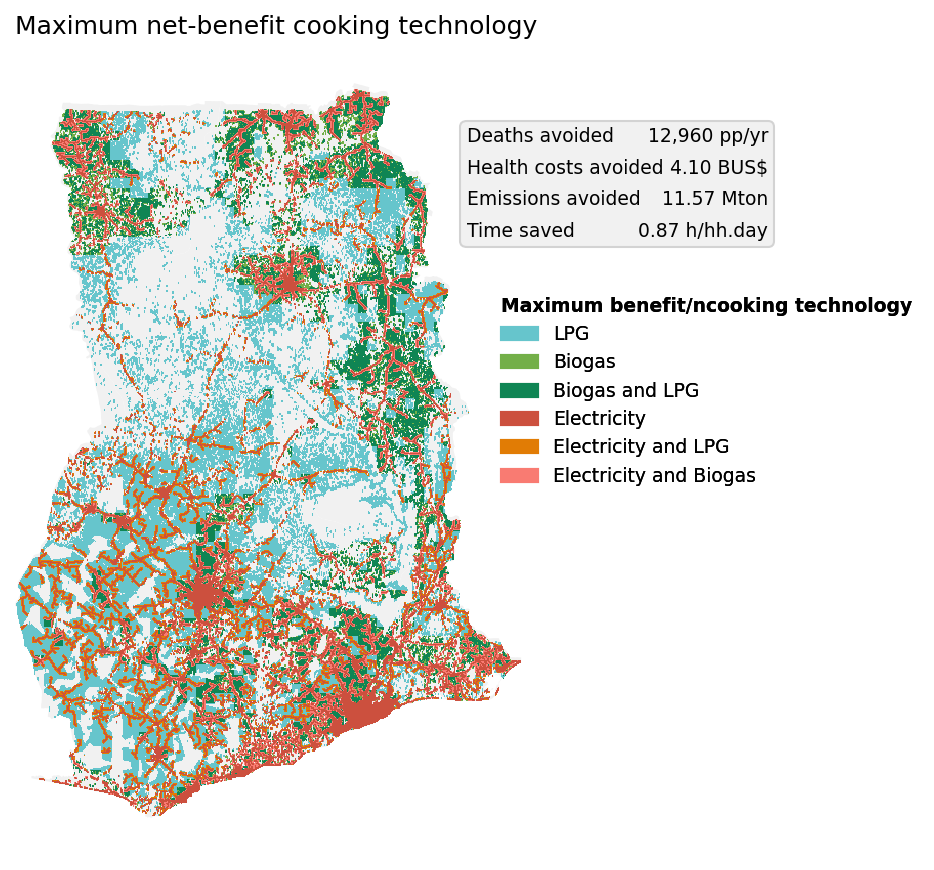

In [8]:
results.plot('max_benefit_tech', cmap=cmap, legend_position=(0.9, 0.7),
             title=f'Maximum net-benefit cooking technology', stats_fontsize=9, figsize=(7, 7),
             labels=labels, legend=True, legend_title='Maximum benefit/ncooking technology', dpi=150,
             legend_prop={'title': {'size': 9, 'weight': 'bold'}, 'size': 9},
             rasterized=True, stats=True, stats_position=(0.85, 0.9), save_style=False)

## 4.5. Printing population split in the study area

Prints the population split describing the percentage of population cooking with different stoves.

Find out more about this function in the [documentation](https://onstove-documentation.readthedocs.io/en/latest/generated/onstove.OnStove.plot_split.html).

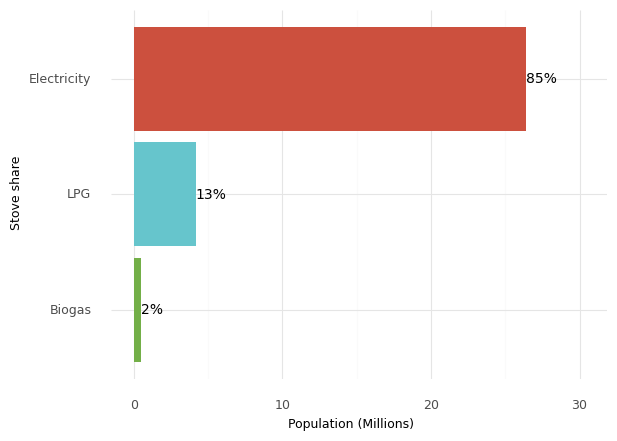

<ggplot: (125606596236)>

In [9]:
results.plot_split(cmap=cmap, labels=labels)

## 4.6. Printing the costs and benefits for each stove category selected

Prints the costs and benefits of each stove type.

Find out more about this function in the [documentation](https://onstove-documentation.readthedocs.io/en/latest/generated/onstove.OnStove.plot_costs_benefits.html).

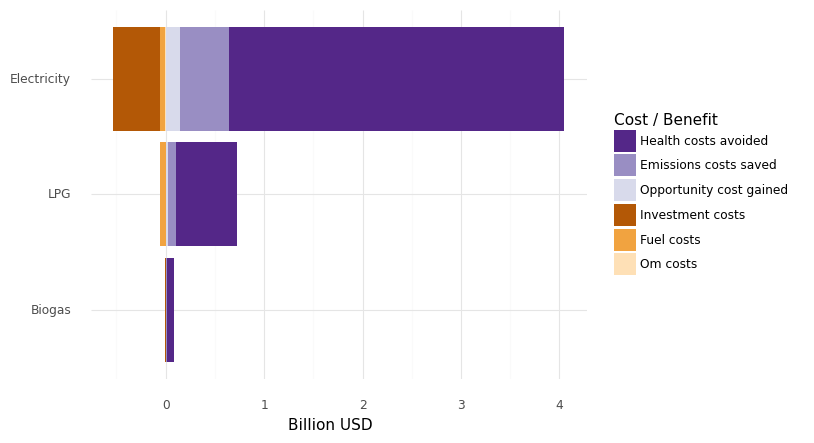

<ggplot: (125574967032)>

In [10]:
results.plot_costs_benefits(labels=labels, height=1.5, width=2)

## 4.7. Printing the range of net-benefit found for each stove per household for each stove selected

Prints the range of net-benefit for each stove included in the results.

Find out more about this function in the [documentation](https://onstove-documentation.readthedocs.io/en/latest/generated/onstove.OnStove.plot_benefit_distribution.html).

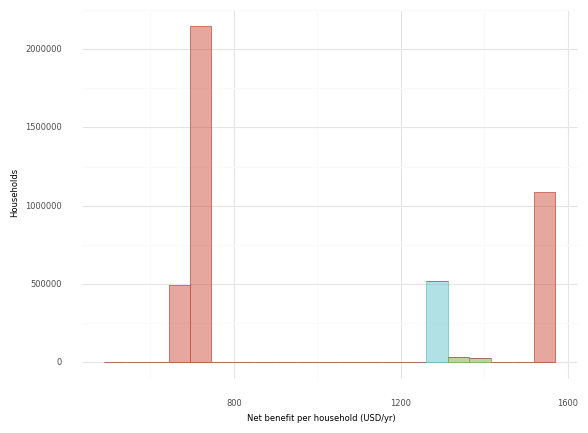

<ggplot: (125606619091)>

In [15]:
results.plot_benefit_distribution(type='histogram', groupby='None', cmap=cmap, labels=labels, height=1.5, width=3.5)

## 4.8. Printing the maximum net-benefit across the study area

Visualize the maximum net-benefit spatially. 

<AxesSubplot:>

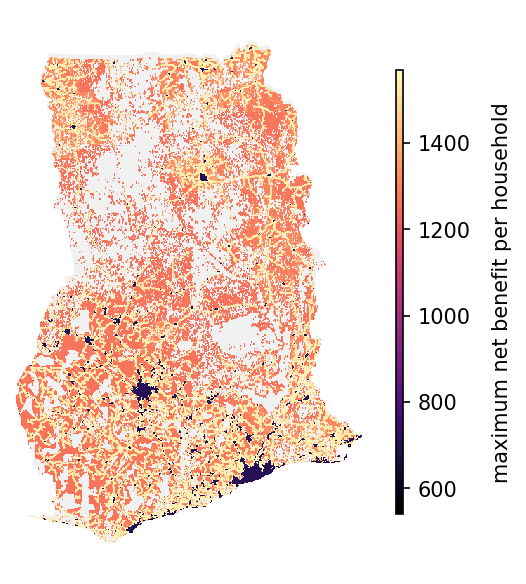

In [12]:
results.plot('maximum_net_benefit', cmap='magma', metric='per_household')

## 4.9. Printing the total costs across the study area

Visualize the total costs spatially.

<AxesSubplot:>

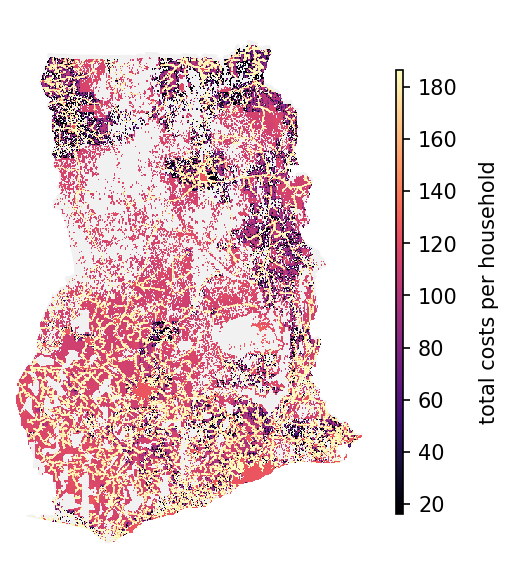

In [13]:
results.gdf['total_costs'] = results.gdf['investment_costs'] - results.gdf['salvage_value'] + results.gdf['fuel_costs'] + results.gdf['om_costs']
results.plot('total_costs', cmap='magma', metric='per_household')

## 4.10. Saving selected results

Saving selected results as rasters.

Find out more about this function in the [documentation](https://onstove-documentation.readthedocs.io/en/latest/generated/onstove.OnStove.to_raster.html).

In [14]:
results.to_raster('max_benefit_tech', cmap=cmap, labels=labels)
results.to_raster('maximum_net_benefit', metric='per_household')
results.to_raster('maximum_net_benefit', metric='total')
results.to_raster('net_benefit_LPG', metric='per_household')
results.to_raster('net_benefit_Biogas', metric='per_household')
results.to_raster('net_benefit_Collected_Improved_Biomass', metric='per_household')
results.to_raster('total_costs', metric='per_household')
results.to_raster('investment_costs', metric='total')
results.to_raster('deaths_avoided', metric='per_100k')
results.to_raster('time_saved', metric='per_household')
results.to_raster('reduced_emissions', metric='total')
results.to_raster('health_costs_avoided', metric='total')
results.to_raster('Households', metric='sum')

Layer saved in .\Rasters\max_benefit_tech.tif

Layer saved in .\Rasters\maximum_net_benefit_per_household.tif

Layer saved in .\Rasters\maximum_net_benefit_total.tif

Layer saved in .\Rasters\net_benefit_LPG_per_household.tif

Layer saved in .\Rasters\net_benefit_Biogas_per_household.tif

Layer saved in .\Rasters\net_benefit_Collected_Improved_Biomass_per_household.tif

Layer saved in .\Rasters\total_costs_per_household.tif

Layer saved in .\Rasters\investment_costs_total.tif

Layer saved in .\Rasters\deaths_avoided_per_100k.tif

Layer saved in .\Rasters\time_saved_per_household.tif

Layer saved in .\Rasters\reduced_emissions_total.tif

Layer saved in .\Rasters\health_costs_avoided_total.tif

Layer saved in .\Rasters\Households_sum.tif

